## Importing Packages, loading data and textfunction

In [3]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import re
import time
import random
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

import kshingle as ks

In [4]:
with open("TVs-all-merged.json") as jsonFile:
    data = json.load(jsonFile)    


In [5]:
##-- Adding data to a list and splitting the modelID column from the rest
file = []
for i in range(len(list(data.values()))):
    if len(list(data.values())[i]) ==1:
        file.append(list(data.values())[i][0])
    else:
        for j in range(len(list(data.values())[i])):
            file.append(list(data.values())[i][1:][0])   
df = pd.DataFrame(file)
# display(df)
x_data = (df[['shop', 'url', 'featuresMap', 'title']])
y_data = (df['modelID'])

pandas.core.frame.DataFrame

## Functions for removing inconsistencies and creating randomnumbers for minhashing

In [4]:
# ##-- Find all duplicate products using their modelID
# y_data2 = pd.DataFrame(y_train)
# dupCountList = []
# realDupl=0
# for i in y_data2['modelID']:
#     if i not in dupCountList:
#         dupCountList.append(i)
#     else:
#         realDupl+=1
# realDupl


In [10]:
# ##-- Split x_data and y_data into x&y train & test data
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.37)


In [6]:
##-- Function to remove inconsistencies in data
def textfunc2(location):
    data = re.sub(r'[^\w\s]','', location)
    items = data.lower()    
    items = items.split()    
    return items
# textfunc2(y_train.iloc[0])

In [17]:
##-- Random number generator function with integer as input
def randomNumberGenerator(value):
    #create list to store random values such that random values are all created once when function is called
    randomNumbers = []
    indexValue = random.randint(0, len(allKeyWords) - 1)
    randomNumbers.append(indexValue)
    
    while value > 0:
        while indexValue in randomNumbers:
            indexValue = random.randint(0, len(allKeyWords) - 1)
        randomNumbers.append(indexValue)
        value=value-1
    return randomNumbers
p = 1583

## Function to process and perform LSH and classification on data

In [20]:
##-- Function to process and perform LSH and classification on data
def fulltransformation(df, x_train, y_train, hashNumber, b, r, thresholdSim):
    time0 = time.time()
    x_train2 = pd.DataFrame(x_train)
    y_train2 = pd.DataFrame(y_train)
        
    t = (1/b) ** (1/r)
    timer=1; timerfin=12
    
    x_data = (df[['shop', 'url', 'featuresMap', 'title']])
    y_data = (df['modelID'])

##-- Data transformations
    listIDs = []
    for i in range(len(y_data)):
        listIDs.append(textfunc2(y_data.iloc[i]))

    for i in range(len(x_data)):
        x_data['title'].iloc[i] = x_data['title'].iloc[i].replace('"', 'inch')
        x_data['title'].iloc[i] = x_data['title'].iloc[i].replace('\"', 'inch')
        x_data['title'].iloc[i] = x_data['title'].iloc[i].replace('inches', 'inch')
        x_data['title'].iloc[i] = x_data['title'].iloc[i].replace('-inch', 'inch')
        x_data['title'].iloc[i] = x_data['title'].iloc[i].replace(' inch', 'inch')
        x_data['title'].iloc[i] = x_data['title'].iloc[i].replace(' hz', 'hz')
        x_data['title'].iloc[i] = x_data['title'].iloc[i].replace('-', '')

    
##-- Add all titles in string format to a list        
    titles_string=[]
    for i in range(len(x_data)):
        titles_string.append(textfunc2(x_data['title'].iloc[i]))  

        
##-- Add all individual lists of strings together in one list (callable by product index)
    totalWords = []
    for i in range(len(x_data)):
        totalWords.append(titles_string[i])

        
##-- Remove all double keywords from totalWords (resulting list consists of only unique keywords)
    allKeyWords = []
    for i in range(len(x_data)):
        for j in range(len(totalWords[i])):
            if totalWords[i][j] not in allKeyWords:
                allKeyWords.append(totalWords[i][j])
      
    allKeyWords.remove('class'); allKeyWords.remove('neweggcom')
    allKeyWords.remove('best'); allKeyWords.remove('buy')
    time1 = time.time()
#     print('keywords', len(allKeyWords))
    print('Ended dataprocessing (', timer, '/',timerfin,')', time1-time0)
    timer+=1
##----------------------------------------------------




##-- Inputmatrix (binary matrix)   
    inputMatrix = np.zeros((len(allKeyWords), len(x_train2)))
    for k in range(len(allKeyWords)):
        for i in range(len(x_train2)):
            if allKeyWords[k] in textfunc2(x_train2['title'].iloc[i]):
                    inputMatrix[k,i] = 1
    time2 = time.time()
    print('Ended inputmatrix computation (', timer, '/',timerfin,')', time2-time0)
    timer+=1
##----------------------------------------------------




   
##-- Minhashing
#Random number generator function with integer as input
    def randomNumberGenerator(value):
        #create list to store random values such that random values are all created once when function is called
        randomNumbers = []
        indexValue = random.randint(0, len(allKeyWords) - 1)
        randomNumbers.append(indexValue)

        while value > 0:
            while indexValue in randomNumbers:
                indexValue = random.randint(0, len(allKeyWords) - 1)
            randomNumbers.append(indexValue)
            value=value-1
        return randomNumbers

    numMinHash = hashNumber #(Input) # about half of number of keywords
    p = 1543

    randomIntA = randomNumberGenerator(numMinHash)
    randomIntB = randomNumberGenerator(numMinHash)
    time3 = time.time()
    print('Ended minhashing computation (', timer, '/',timerfin,')', time3-time0)
    timer+=1
##----------------------------------------------------





##-- SignatureMatrix
    signatureMatrix = []
    for i in range(len(x_train2)): #Loop over all products in sample
        signature = []
        for j in range(0, numMinHash): #Do this numMinHash times
            minHashValue = 2**32 - 1
            for k in range(len(allKeyWords)): #Loop over all keywords
                if inputMatrix[k,i] == 1:
                    hashValue = (randomIntA[j] + k * randomIntB[j]) % p
                    if hashValue < minHashValue:                    
                        minHashValue = hashValue 

            signature.append(minHashValue)     
        signatureMatrix.append(signature)
    time4 = time.time()
    print('Ended signaturematrix computation (', timer, '/',timerfin,')', time4-time0)
    timer+=1
    signatureMatrixFin = np.transpose(pd.DataFrame(signatureMatrix))
##----------------------------------------------------




    

##--Splitting signaturematrix in corresponding rows and bands, depending on values for b and r    
    z = np.arange(0,numMinHash,r)
    bandsDict = {}
    for i in range(len((z))-1):
        bandsDict["band{0}".format(i)]=signatureMatrixFin[z[i]:z[i+1]][:]
    bandsDict["band{0}".format(b-1)]=signatureMatrixFin[z[b-1]:][:]    
    time5 = time.time()
    print('Ended splitting signaturematrix into bands (', timer, '/',timerfin,')', time5-time0)
    timer+=1
##----------------------------------------------------



    
    
##--Create hashvalues for columns of each band represented by their integers as strings
##4 rows with values 4, 64, 49, 3 --> 464493
    values = bandsDict.values()
    keys = bandsDict.keys() #keys = ['band0', 'band1', ... , 'bandb']

    hashValBand = {}; hashValBandS = {}; hashValBandDupl = {}; hashValBandNoDupl = {}
    for i in range(0,b):
        hashValBandS[i] = {}
        for j in range(len(x_train)):
            valueHash1 = bandsDict['band'+str(i)][:][j]
            valueHash2 = [str(int) for int in valueHash1]
            valueHash3 = ''.join(valueHash2)
            if valueHash3 not in hashValBandS[i].keys():
                hashValBandS[i][valueHash3] = [j]
            else:
                hashValBandS[i][valueHash3].append(j)

        hashValBandDupl[i] = {}
        hashValBandNoDupl[i] = {}

        for key in hashValBandS[i]:
            if len(hashValBandS[i][key]) > 1:
                  hashValBandDupl[i][key] = hashValBandS[i][key]
            else:
                hashValBandNoDupl[i][key] = hashValBandS[i][key]
    time6 = time.time()
    print('Ended creating hashvalues for bands (', timer, '/',timerfin,')', time6-time0)
    timer+=1
##----------------------------------------------------




##--Extract all candidate pairs of all bands for further comparison and renaming
    candidateBuck = {}
    noCandidateBuck = {}
    for i in range(0,b):
        candidateBuck['candidatesBuck%s' % i] = list(hashValBandDupl[i].values())
        noCandidateBuck['noCandidatesBuck%s' % i] = list(hashValBandNoDupl[i].values())
    pairsB = {}
    noPairsB = {}
    for i in range(0,b):   
        pairsB[i] = candidateBuck['candidatesBuck'+str(i)]
        noPairsB[i] = noCandidateBuck['noCandidatesBuck'+str(i)]
        
##-- Add all (non)candidate pairs to a list
    allPairs = []
    allNoPairs = []
    for i in range(0,b):
        allPairs.append(pairsB[i])
        allNoPairs.append(noPairsB[i]) 
        
##-- Remove duplicate (non)candidate pairs 
    allPairsDef = []
    allNonPairsDef = []
    for i in range(b):
        for j in range(len(allPairs[i])):
            if allPairs[i][j] not in allPairsDef:
                allPairsDef.append(allPairs[i][j])

    for i in range(b):
        for j in range(len(allNoPairs[i])):
            if allNoPairs[i][j] not in allNonPairsDef:
                allNonPairsDef.append(allNoPairs[i][j])
    time7 = time.time()
    print('Ended removing (non)duplicate pairs from allPairsDef (', timer, '/',timerfin,')', time7-time0)
    timer+=1
##----------------------------------------------------

    
    
    
        
##-- To compare only pairs (two products), take care of the buckets with multiple items
##-- by extracting and removing, and later adding in pairs
    pairsTwoPlus = [] 
    for i in range(len(allPairsDef)):
        if(len(allPairsDef[i]) > 2):
            pairsTwoPlus.append(allPairsDef[i]) #Extract all buckets with more than 2 products

    
##-- Make new pairs from buckets with more than 2 items  
    pairsTwoPlusDoubles = []
    for item in range(len(pairsTwoPlus)):
        newComp = [(item1, item2) for idx, item1 in enumerate(pairsTwoPlus[item]) for item2 in pairsTwoPlus[item][idx + 1:]]
        for item1,item2 in newComp: #Add all possible combinations of pairs from buckets with more than 2 products to a list
            if [item2, item1] not in pairsTwoPlusDoubles:
                    pairsTwoPlusDoubles.append([item1,item2])
    
    
##-- Remove buckets with more than 2 items
    for removeMoreTwo in range(len(pairsTwoPlus)):
        allPairsDef.remove(pairsTwoPlus[removeMoreTwo])

##-- Add all possible combinations of pairs from buckets > 2 products back to original list    
    for i in pairsTwoPlusDoubles:
        allPairsDef.append(i)

    time8 = time.time()
    print('Ended computing all bucketpairs across bands (', timer, '/',timerfin,')', time8-time0)
    timer+=1
##----------------------------------------------------




##-- Find all duplicate products using their modelID
    dupID = y_train2.pivot_table(columns=['modelID'], aggfunc='size')
    dupID = dupID[dupID > 1]
    dupID2 = pd.DataFrame(dupID)
#    print("Total amount of double products:", sum(dupID2[0])) #691
#    print("Total ammount of duplicate products:", len(dupID)) #329
    Dn = 691 #total amount of double products in data
            
      
    
##-- Products in the same shop are assumed not to be duplicates
    TP = 0; FP = 0
    for i in (allPairsDef):
        if y_train2['modelID'].iloc[i[0]] == y_train2['modelID'].iloc[i[1]]:
#             if(x_train2['shop'].iloc[i[0]] != x_train2['shop'].iloc[i[1]]):
#                 print('from different shops')
            TP+=1 #same shop condition removed 
        else:
#             print('modelIDs not equal', i, y_train2['modelID'].iloc[i[0]], y_train2['modelID'].iloc[i[1]])
            FP +=1   
    Df = TP
    Nc = len(allPairsDef)
    PQ = Df / Nc
    PC = Df / Dn
    print("Df", Df)
#     print("Df:", Df, "Dn:", Dn, "Nc:", Nc, "TP:", TP, "FP:", FP, "PQ:", PQ, "PC:", PC)
    F1star = (2 * PQ * PC) / (PQ + PC)
    time9 = time.time()
    print('Ended LSH performance (', timer, '/',timerfin,')', time9-time0)
    timer+=1   
##----------------------------------------------------






##-- Similarity measures
    def jaccard(prod1, prod2):
        intersec = np.logical_and(prod1,prod2)
        union = np.logical_or(prod1, prod2)
        similarVal = intersec.sum() / float(union.sum())
        return similarVal

    def cosine(prod1, prod2):
        value = 0; length1 = 0; length2 = 0
        for i in range(len(prod1)):
            value += prod1[i]*prod2[i]
            length1 += (prod1[i])**2
            length2 += (prod2[i])**2
        sim = value / (np.sqrt(length1) * np.sqrt(length2))
        return sim
    
    jaccardNew = np.zeros((len(allPairsDef)))
    cosineNew = np.zeros((len(allPairsDef)))

    for i in range(len(allPairsDef)):
        jaccardNew[i] = jaccard(inputMatrix[:, allPairsDef[i][0]], inputMatrix[:, allPairsDef[i][1]])
        cosineNew[i] = cosine(inputMatrix[:, allPairsDef[i][0]], inputMatrix[:, allPairsDef[i][1]])

    combinedSim = np.zeros((len(allPairsDef)))
    for i in range(len(allPairsDef)):
        if jaccardNew[i] >= thresholdSim and cosineNew[i] >= thresholdSim:
            combinedSim[i] = 1

    dfound = 0
    for i in range(len(allPairsDef)):
        if combinedSim[i] == 1:
            a = allPairsDef[i]
            if y_train2['modelID'].iloc[a[0]] == y_train2['modelID'].iloc[a[1]]:
                dfound +=1 #Also here has the same webshop restriction been removed

    DfSim = dfound #Total TP
    NcSim = len(combinedSim) #total comparisons made
    DnSim = Dn #remains the same for each subset
    
    PQSim = DfSim / NcSim
    PCSim = DfSim / DnSim
    F1Sim = (2 * PQSim * PCSim) / (PQSim + PCSim)    
    
    time10 = time.time()
    print('Ended computing jaccard and cosine similarities (', timer, '/',timerfin,')', time10-time0)
    timer+=1

            
#     print('jaccardNew', jaccardNew)
#     print('cosineNew', cosineNew)
#     print('combined', combinedSim)
    
    
##-- Classification using jaccard- & cosine similarities and threshold

#     print('LSH: [t, b, r, F1*]', t, b, r, F1star)
#     print('Classification: [t, b, r, F1]', t, b, r, F1Sim)
    maxCom = 1624 * 1623 * 0.5
    fracOfCompLSH = Nc / maxCom
    fracOfComp = NcSim / maxCom
    perfLSH = [PQ, PC, F1star, t, fracOfComp]
    perfSim = [PQSim, PCSim, F1Sim, t, fracOfComp]
    print('')
    print('perfLSH', perfLSH)
    print('perfSim', perfSim)
    print('')
    return perfLSH, perfSim   
 

In [31]:
##--Bootstrap
numBootstrap = 5
sizeBootstrap = int(len(df) * 0.63) #Retain about 1000 products in each sample

bootdata = resample(df, n_samples = sizeBootstrap)
x_boot = (bootdata[['shop', 'url', 'featuresMap', 'title']])
y_boot = (bootdata['modelID'])


## Bootstrapping

In [51]:
##-- Function to average estimates over bootstraps
def bootEval():
    PCStar1 = []; PC1 = []
    PQStar1 = []; PQ1 = []
    F1Star1 = []; F11 = []
    fracOfCompstar = []
    fracOfComp1 = []
    
    PQstar1 = (output1LSH[0] + output2LSH[0] + output3LSH[0] + output4LSH[0] + output5LSH[0]) / len(output1LSH)
    PCstar1 = (output1LSH[1] + output2LSH[1] + output3LSH[1] + output4LSH[1] + output5LSH[1]) / len(output1LSH)
    F1star1 = (output1LSH[2] + output2LSH[2] + output3LSH[2] + output4LSH[2] + output5LSH[2]) / len(output1LSH)
    fracOfCompstar = (output1LSH[4] + output2LSH[4] + output3LSH[4] + output4LSH[4] + output5LSH[4]) / len(output1LSH)

    PQ1 = (output1[0] + output2[0] + output3[0] + output4[0] + output5[0]) / len(output1)
    PC1 = (output1[1] + output2[1] + output3[1] + output4[1] + output5[1]) / len(output1)
    F11 = (output1[2] + output2[2] + output3[2] + output4[2] + output5[2]) / len(output1)
    fracOfComp1 = (output1[4] + output2[4] + output3[4] + output4[4] + output5[4]) / len(output1)
    print('PQstar1, PCstar1, F1star1, fracOfCompstar, PQ1, PC1, F11, fracOfComp1')
    return PQstar1, PCstar1, F1star1, fracOfCompstar, PQ1, PC1, F11, fracOfComp1

In [52]:
# #b=1, r=700
# output1LSH = [0.927710843373494, 0.6685962373371924, 0.7771236333052984, 1.0, 0.00037788077178733053]

# output1 = [0.927710843373494, 0.6685962373371924, 0.7771236333052984, 1.0, 0.00037788077178733053]
# output2LSH = [0.9748062015503876, 0.7279305354558611, 0.8334714167357083, 1.0, 0.0003915391129362702]
# output2 = [0.9748062015503876, 0.7279305354558611, 0.8334714167357083, 1.0, 0.0003915391129362702]
# output3LSH = [0.9724950884086444, 0.7163531114327062, 0.8249999999999998, 1.0, 0.00038622753582279363]
# output3 = [0.9724950884086444, 0.7163531114327062, 0.8249999999999998, 1.0, 0.00038622753582279363]
# output4LSH = [0.9507186858316222, 0.6700434153400868, 0.7860780984719864, 1.0, 0.0003695340077518674]
# output4 = [0.9507186858316222, 0.6700434153400868, 0.7860780984719864, 1.0, 0.0003695340077518674]
# output5LSH = [0.9690522243713733, 0.7250361794500724, 0.8294701986754967, 1.0, 0.00039229790966676683]
# output5 = [0.9690522243713733, 0.7250361794500724, 0.8294701986754967, 1.0, 0.00039229790966676683]
# bootEval()

PQstar1, PCstar1, F1star1, fracOfCompstar, PQ1, PC1, F11, fracOfComp1


(0.9589566087071043,
 0.7015918958031838,
 0.8102286694376979,
 0.0003834958675930057,
 0.9589566087071043,
 0.7015918958031838,
 0.8102286694376979,
 0.0003834958675930057)

In [53]:
# #b=14, r=50
# output1LSH = [0.9511343804537522, 0.788712011577424, 0.8623417721518987, 0.9485875913936671, 0.0004347905265745791]
# output1 = [0.9511343804537522, 0.788712011577424, 0.8623417721518987, 0.9485875913936671, 0.0004347905265745791]
# output2LSH = [0.9149722735674677, 0.7163531114327062, 0.8035714285714285, 0.9485875913936671, 0.00041050903119868636]
# output2 = [0.9149722735674677, 0.7163531114327062, 0.8035714285714285, 0.9485875913936671, 0.00041050903119868636]
# output3LSH = [0.9464627151051626, 0.7163531114327062, 0.8154859967051071, 0.9485875913936671, 0.0003968506900497467]
# output3 = [0.9464627151051626, 0.7163531114327062, 0.8154859967051071, 0.9485875913936671, 0.0003968506900497467]
# output4LSH = [0.9574898785425101, 0.6845151953690304, 0.7983122362869197, 0.9485875913936671, 0.00037484558486534393]
# output4 = [0.9574898785425101, 0.6845151953690304, 0.7983122362869197, 0.9485875913936671, 0.00037484558486534393]
# output5LSH = [0.9569471624266145, 0.7076700434153401, 0.8136439267886856, 0.9485875913936671, 0.00038774512928378696]
# output5 = [0.9569471624266145, 0.7076700434153401, 0.8136439267886856, 0.9485875913936671, 0.00038774512928378696]
# bootEval()

PQstar1, PCstar1, F1star1, fracOfCompstar, PQ1, PC1, F11, fracOfComp1


(0.9454012820191015,
 0.7227206946454414,
 0.8186710721008079,
 0.0004009481923944286,
 0.9454012820191015,
 0.7227206946454414,
 0.8186710721008079,
 0.0004009481923944286)

In [54]:
# #b=25, r=28
# output1LSH = [0.9383802816901409, 0.7713458755426917, 0.846703733121525, 0.8914019321842713, 0.00043099654292209585]
# output1 = [0.9383802816901409, 0.7713458755426917, 0.846703733121525, 0.8914019321842713, 0.00043099654292209585]
# output2LSH = [0.9672447013487476, 0.7264833574529667, 0.8297520661157024, 0.8914019321842713, 0.0003938155031277601]
# output2 = [0.9672447013487476, 0.7264833574529667, 0.8297520661157024, 0.8914019321842713, 0.0003938155031277601]
# output3LSH = [0.9142857142857143, 0.7872648335745297, 0.8460342146189735, 0.8914019321842713, 0.00045148405464550534]
# output3 = [0.9142857142857143, 0.7872648335745297, 0.8460342146189735, 0.8914019321842713, 0.00045148405464550534]
# output4LSH = [0.9354243542435424, 0.7337192474674384, 0.8223844282238442, 0.8914019321842713, 0.000411267827929183]
# output4 = [0.9354243542435424, 0.7337192474674384, 0.8223844282238442, 0.8914019321842713, 0.000411267827929183]
# output5LSH = [0.954954954954955, 0.7670043415340086, 0.8507223113964687, 0.8914019321842713, 0.0004211321854256394]
# output5 = [0.954954954954955, 0.7670043415340086, 0.8507223113964687, 0.8914019321842713, 0.0004211321854256394]
# bootEval()

PQstar1, PCstar1, F1star1, fracOfCompstar, PQ1, PC1, F11, fracOfComp1


(0.94205800130462,
 0.757163531114327,
 0.8391193506953029,
 0.0004217392228100367,
 0.94205800130462,
 0.757163531114327,
 0.8391193506953029,
 0.0004217392228100367)

In [55]:
# #b = 35, r=20
# output1LSH = [0.8607809847198642, 0.7337192474674384, 0.7921874999999999, 0.837137116364921, 0.00044693127426252547]
# output1 = [0.8607809847198642, 0.7337192474674384, 0.7921874999999999, 0.837137116364921, 0.00044693127426252547]
# output2LSH = [0.7961783439490446, 0.723589001447178, 0.7581501137225171, 0.837137116364921, 0.0004765243467518947]
# output2 = [0.7961783439490446, 0.723589001447178, 0.7581501137225171, 0.837137116364921, 0.0004765243467518947]
# output3LSH = [0.8384491114701131, 0.7510853835021708, 0.7923664122137404, 0.837137116364921, 0.00046969517617742487]
# output3 = [0.8384491114701131, 0.7510853835021708, 0.7923664122137404, 0.837137116364921, 0.00046969517617742487]
# output4LSH = [0.8699324324324325, 0.7452966714905933, 0.8028059236165237, 0.837137116364921, 0.0004492076644540154]
# output4 = [0.8699324324324325, 0.7452966714905933, 0.8028059236165237, 0.837137116364921, 0.0004492076644540154]
# output5LSH = [0.8207236842105263, 0.7221418234442837, 0.7682832948421863, 0.837137116364921, 0.00046134841214196177]
# output5 = [0.8207236842105263, 0.7221418234442837, 0.7682832948421863, 0.837137116364921, 0.00046134841214196177]
# bootEval()

PQstar1, PCstar1, F1star1, fracOfCompstar, PQ1, PC1, F11, fracOfComp1


(0.8372129113563961,
 0.7351664254703327,
 0.7827586488789935,
 0.0004607413747575644,
 0.8372129113563961,
 0.7351664254703327,
 0.7827586488789935,
 0.0004607413747575644)

In [56]:
# #b=50, r=14
# output1LSH = [0.6206030150753769, 1.0723589001447178, 0.786206896551724, 0.7562144986495706, 0.0009060032962129972]
# output1 = [0.6206030150753769, 1.0723589001447178, 0.786206896551724, 0.7562144986495706, 0.0009060032962129972]
# output2LSH = [0.6596385542168675, 0.9507959479015919, 0.7788974510966211, 0.7562144986495706, 0.0007557615435746611]
# output2 = [0.6596385542168675, 0.9507959479015919, 0.7788974510966211, 0.7562144986495706, 0.0007557615435746611]
# output3LSH = [0.5301857585139319, 0.9913169319826338, 0.6908724155320223, 0.7562144986495706, 0.0009803653758016688]
# output3 = [0.5301857585139319, 0.9913169319826338, 0.6908724155320223, 0.7562144986495706, 0.0009803653758016688]
# output4LSH = [0.5303703703703704, 1.036179450072359, 0.7016168544830965, 0.7562144986495706, 0.0010243755861704743]
# output4 = [0.5303703703703704, 1.036179450072359, 0.7016168544830965, 0.7562144986495706, 0.0010243755861704743]
# output5LSH = [0.5651162790697675, 1.0549927641099854, 0.7359919232710751, 0.7562144986495706, 0.0009788477823406755]
# output5 = [0.5651162790697675, 1.0549927641099854, 0.7359919232710751, 0.7562144986495706, 0.0009788477823406755]
# bootEval()

PQstar1, PCstar1, F1star1, fracOfCompstar, PQ1, PC1, F11, fracOfComp1


(0.5811827954492628,
 1.0211287988422575,
 0.7387171081869077,
 0.0009290707168200954,
 0.5811827954492628,
 1.0211287988422575,
 0.7387171081869077,
 0.0009290707168200954)

In [57]:
# #b=100, r=7
# output1LSH = [0.18242221261884184, 4.88712011577424, 0.35171587772743845, 0.5179474679231212, 0.014046845074953941]
# output1 = [0.18242221261884184, 4.88712011577424, 0.35171587772743845, 0.5179474679231212, 0.014046845074953941]
# output2LSH = [0.20709480825619503, 5.21273516642547, 0.39836319398363196, 0.5179474679231212, 0.013197751533528193]
# output2 = [0.20709480825619503, 5.21273516642547, 0.39836319398363196, 0.5179474679231212, 0.013197751533528193]
# output3LSH = [0.2144910530947492, 5.290882778581765, 0.41226883175462337, 0.5179474679231212, 0.012933690271315358]
# output3 = [0.2144910530947492, 5.290882778581765, 0.41226883175462337, 0.5179474679231212, 0.012933690271315358]
# output4LSH = [0.23065941536369816, 4.91027496382055, 0.44062073891305764, 0.5179474679231212, 0.011161899905605687]
# output4 = [0.23065941536369816, 4.91027496382055, 0.44062073891305764, 0.5179474679231212, 0.011161899905605687]
# output5LSH = [0.17019836738146596, 5.8234442836468885, 0.33073066491329, 0.5179474679231212, 0.01794023109913224]
# output5 = [0.17019836738146596, 5.8234442836468885, 0.33073066491329, 0.5179474679231212, 0.01794023109913224]
# bootEval()

PQstar1, PCstar1, F1star1, fracOfCompstar, PQ1, PC1, F11, fracOfComp1


(0.20097317134299003,
 5.224891461649784,
 0.3867398614584083,
 0.013856083576907086,
 0.20097317134299003,
 5.224891461649784,
 0.3867398614584083,
 0.013856083576907086)

In [58]:
# #b=140, r=5
# output1LSH = [0.10810490208677256, 15.826338639652677, 0.2147429603738758, 0.3721983065876935, 0.07676063605377137]
# output1 = [0.10810490208677256, 15.826338639652677, 0.2147429603738758, 0.3721983065876935, 0.07676063605377137]
# output2LSH = [0.11065396847771503, 18.17655571635311, 0.21996882607401178, 0.3721983065876935, 0.08612874048848299]
# output2 = [0.11065396847771503, 18.17655571635311, 0.21996882607401178, 0.3721983065876935, 0.08612874048848299]
# output3LSH = [0.10748099137300775, 17.02026049204052, 0.21361304091177405, 0.3721983065876935, 0.08303057343786517]
# output3 = [0.10748099137300775, 17.02026049204052, 0.21361304091177405, 0.3721983065876935, 0.08303057343786517]
# output4LSH = [0.1073212079125009, 15.208393632416787, 0.21313836044294812, 0.3721983065876935, 0.07430213464696224]
# output4 = [0.1073212079125009, 15.208393632416787, 0.21313836044294812, 0.3721983065876935, 0.07430213464696224]
# output5LSH = [0.11352817565828974, 15.324167872648335, 0.2253865883379628, 0.3721983065876935, 0.07077448864688332]
# output5 = [0.11352817565828974, 15.324167872648335, 0.2253865883379628, 0.3721983065876935, 0.07077448864688332]
# bootEval()

PQstar1, PCstar1, F1star1, fracOfCompstar, PQ1, PC1, F11, fracOfComp1


(0.1094178491016572,
 16.311143270622285,
 0.21736995522811448,
 0.07819931465479302,
 0.1094178491016572,
 16.311143270622285,
 0.21736995522811448,
 0.07819931465479302)

In [33]:
##1 Pair Completeness
pairs = [(1, 700), (14, 50), (25, 28), (35, 20), (50, 14), (100,7), (140, 4), (175, 4), (350, 2), (700, 1)]


## Let computations run once (prior to bootstrapping)

In [32]:
print(pairs[0])
y = fulltransformation(df, x_boot, y_boot, 700, 1, 700, 0.85)

(1, 700)


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


keywords 1534
Ended dataprocessing ( 1 / 12 ) 0.7795257568359375
Ended inputmatrix computation ( 2 / 12 ) 12.818022727966309
Ended minhashing computation ( 3 / 12 ) 12.831799030303955
Ended signaturematrix computation ( 4 / 12 ) 261.5259299278259
Ended splitting signaturematrix into bands ( 5 / 12 ) 261.6640238761902
Ended creating hashvalues for bands ( 6 / 12 ) 261.8805978298187
Ended removing (non)duplicate pairs from allPairsDef ( 7 / 12 ) 261.883065700531
Ended computing all bucketpairs across bands ( 8 / 12 ) 261.8848078250885
Df 508
Ended LSH performance ( 9 / 12 ) 261.89098477363586
Ended computing jaccard and cosine similarities ( 10 / 12 ) 262.5846257209778
AllkeyWords: 1534

perfLSH [0.9442379182156134, 0.7351664254703328, 0.8266883645240033, 1.0, 0.00040823264100719645]
perfSim [0.9442379182156134, 0.7351664254703328, 0.8266883645240033, 1.0, 0.00040823264100719645]



In [34]:
print(pairs[1])
y = fulltransformation(df, x_boot, y_boot, 700, 14, 50, 0.85)

(14, 50)


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


keywords 1534
Ended dataprocessing ( 1 / 12 ) 0.7662959098815918
Ended inputmatrix computation ( 2 / 12 ) 12.768630981445312
Ended minhashing computation ( 3 / 12 ) 12.782347917556763
Ended signaturematrix computation ( 4 / 12 ) 260.78527212142944
Ended splitting signaturematrix into bands ( 5 / 12 ) 260.9162919521332
Ended creating hashvalues for bands ( 6 / 12 ) 261.7309422492981
Ended removing (non)duplicate pairs from allPairsDef ( 7 / 12 ) 261.7633080482483
Ended computing all bucketpairs across bands ( 8 / 12 ) 261.76511907577515
Df 508
Ended LSH performance ( 9 / 12 ) 261.7710750102997
Ended computing jaccard and cosine similarities ( 10 / 12 ) 262.47446608543396
AllkeyWords: 1534

perfLSH [0.9442379182156134, 0.7351664254703328, 0.8266883645240033, 0.9485875913936671, 0.00040823264100719645]
perfSim [0.9442379182156134, 0.7351664254703328, 0.8266883645240033, 0.9485875913936671, 0.00040823264100719645]



In [35]:
print(pairs[2])
y = fulltransformation(df, x_boot, y_boot, 700, 25, 28, 0.85)

(25, 28)


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


keywords 1534
Ended dataprocessing ( 1 / 12 ) 0.7553648948669434
Ended inputmatrix computation ( 2 / 12 ) 12.975375890731812
Ended minhashing computation ( 3 / 12 ) 12.989080667495728
Ended signaturematrix computation ( 4 / 12 ) 262.1363220214844
Ended splitting signaturematrix into bands ( 5 / 12 ) 262.26972794532776
Ended creating hashvalues for bands ( 6 / 12 ) 263.51937985420227
Ended removing (non)duplicate pairs from allPairsDef ( 7 / 12 ) 263.57709288597107
Ended computing all bucketpairs across bands ( 8 / 12 ) 263.5790538787842
Df 514
Ended LSH performance ( 9 / 12 ) 263.58538603782654
Ended computing jaccard and cosine similarities ( 10 / 12 ) 264.304655790329
AllkeyWords: 1534

perfLSH [0.927797833935018, 0.743849493487699, 0.8257028112449799, 0.8914019321842713, 0.0004203733886951428]
perfSim [0.927797833935018, 0.743849493487699, 0.8257028112449799, 0.8914019321842713, 0.0004203733886951428]



In [36]:
print(pairs[3])
y = fulltransformation(df, x_boot, y_boot, 700, 35, 20, 0.85)

(35, 20)


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


keywords 1534
Ended dataprocessing ( 1 / 12 ) 0.7460169792175293
Ended inputmatrix computation ( 2 / 12 ) 12.76367712020874
Ended minhashing computation ( 3 / 12 ) 12.77782917022705
Ended signaturematrix computation ( 4 / 12 ) 262.1554958820343
Ended splitting signaturematrix into bands ( 5 / 12 ) 262.2930850982666
Ended creating hashvalues for bands ( 6 / 12 ) 263.950248003006
Ended removing (non)duplicate pairs from allPairsDef ( 7 / 12 ) 264.03104519844055
Ended computing all bucketpairs across bands ( 8 / 12 ) 264.03387212753296
Df 543
Ended LSH performance ( 9 / 12 ) 264.0407381057739
Ended computing jaccard and cosine similarities ( 10 / 12 ) 264.8713159561157
AllkeyWords: 1534

perfLSH [0.8524332810047096, 0.7858176555716353, 0.8177710843373494, 0.837137116364921, 0.00048335351732636453]
perfSim [0.8524332810047096, 0.7858176555716353, 0.8177710843373494, 0.837137116364921, 0.00048335351732636453]



In [37]:
print(pairs[4])
y = fulltransformation(df, x_boot, y_boot, 700, 50, 14, 0.85)

(50, 14)
keywords 1534
Ended dataprocessing ( 1 / 12 ) 0.7632009983062744


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Ended inputmatrix computation ( 2 / 12 ) 13.064847946166992
Ended minhashing computation ( 3 / 12 ) 13.078565120697021
Ended signaturematrix computation ( 4 / 12 ) 262.7527930736542
Ended splitting signaturematrix into bands ( 5 / 12 ) 262.88704204559326
Ended creating hashvalues for bands ( 6 / 12 ) 265.21844601631165
Ended removing (non)duplicate pairs from allPairsDef ( 7 / 12 ) 265.3334410190582
Ended computing all bucketpairs across bands ( 8 / 12 ) 265.3434360027313
Df 662
Ended LSH performance ( 9 / 12 ) 265.35477113723755
Ended computing jaccard and cosine similarities ( 10 / 12 ) 266.8326680660248
AllkeyWords: 1534

perfLSH [0.5905441570026762, 0.9580318379160637, 0.7306843267108168, 0.7562144986495706, 0.000850611134886742]
perfSim [0.5905441570026762, 0.9580318379160637, 0.7306843267108168, 0.7562144986495706, 0.000850611134886742]



In [38]:
print(pairs[5])
y = fulltransformation(df, x_boot, y_boot, 700, 100, 7, 0.85)

(100, 7)
keywords 1534
Ended dataprocessing ( 1 / 12 ) 0.7416110038757324


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Ended inputmatrix computation ( 2 / 12 ) 12.99350905418396
Ended minhashing computation ( 3 / 12 ) 13.00746202468872
Ended signaturematrix computation ( 4 / 12 ) 263.6229290962219
Ended splitting signaturematrix into bands ( 5 / 12 ) 263.762247800827
Ended creating hashvalues for bands ( 6 / 12 ) 268.21412086486816
Ended removing (non)duplicate pairs from allPairsDef ( 7 / 12 ) 268.45466685295105
Ended computing all bucketpairs across bands ( 8 / 12 ) 271.0447299480438
Df 3541
Ended LSH performance ( 9 / 12 ) 271.18752884864807
Ended computing jaccard and cosine similarities ( 10 / 12 ) 291.8862090110779
AllkeyWords: 1534

perfLSH [0.2217560120240481, 5.124457308248915, 0.425115553154451, 0.5179474679231212, 0.01211646619257047]
perfSim [0.2217560120240481, 5.124457308248915, 0.425115553154451, 0.5179474679231212, 0.01211646619257047]



In [39]:
print(pairs[6])
y = fulltransformation(df, x_boot, y_boot, 700, 140, 5, 0.85)

(140, 4)


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


keywords 1534
Ended dataprocessing ( 1 / 12 ) 0.7564749717712402
Ended inputmatrix computation ( 2 / 12 ) 12.943886756896973
Ended minhashing computation ( 3 / 12 ) 12.957985877990723
Ended signaturematrix computation ( 4 / 12 ) 263.501101732254
Ended splitting signaturematrix into bands ( 5 / 12 ) 263.64146900177
Ended creating hashvalues for bands ( 6 / 12 ) 269.78521609306335
Ended removing (non)duplicate pairs from allPairsDef ( 7 / 12 ) 270.2292790412903
Ended computing all bucketpairs across bands ( 8 / 12 ) 355.3272457122803
Df 10871
Ended LSH performance ( 9 / 12 ) 356.1198818683624
Ended computing jaccard and cosine similarities ( 10 / 12 ) 473.296835899353
AllkeyWords: 1534

perfLSH [0.12052240047007173, 15.732272069464544, 0.23921223456925952, 0.3721983065876935, 0.06844270629406712]
perfSim [0.12052240047007173, 15.732272069464544, 0.23921223456925952, 0.3721983065876935, 0.06844270629406712]



In [40]:
print(pairs[7]) #hier
y = fulltransformation(df, x_boot, y_boot, 700, 175, 4, 0.85)

(175, 4)
keywords 1534
Ended dataprocessing ( 1 / 12 ) 0.7903280258178711


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Ended inputmatrix computation ( 2 / 12 ) 13.048805236816406
Ended minhashing computation ( 3 / 12 ) 13.062582015991211
Ended signaturematrix computation ( 4 / 12 ) 264.1247169971466
Ended splitting signaturematrix into bands ( 5 / 12 ) 264.26188802719116
Ended creating hashvalues for bands ( 6 / 12 ) 271.86243295669556
Ended removing (non)duplicate pairs from allPairsDef ( 7 / 12 ) 272.50272011756897
Ended computing all bucketpairs across bands ( 8 / 12 ) 1387.2159922122955
Df 23232
Ended LSH performance ( 9 / 12 ) 1390.0168220996857
Ended computing jaccard and cosine similarities ( 10 / 12 ) 1807.9947080612183
AllkeyWords: 1534

perfLSH [0.07284265710146927, 33.62083936324168, 0.1453703558858037, 0.274941620352113, 0.24200607644421782]
perfSim [0.07284265710146927, 33.62083936324168, 0.1453703558858037, 0.274941620352113, 0.24200607644421782]



## Bootstrapping & Results

In [42]:
for i in range(numBootstrap):
    bootdata = resample(df, n_samples = sizeBootstrap)
    x_boot = (bootdata[['shop', 'url', 'featuresMap', 'title']])
    y_boot = (bootdata['modelID'])
    fulltransformation(df, x_boot, y_boot, 700, 1, 700, 0.85)

keywords 1534
Ended dataprocessing ( 1 / 12 ) 0.7352092266082764
Ended inputmatrix computation ( 2 / 12 ) 12.780055046081543
Ended minhashing computation ( 3 / 12 ) 12.7938392162323
Ended signaturematrix computation ( 4 / 12 ) 260.24326515197754
Ended splitting signaturematrix into bands ( 5 / 12 ) 260.3764491081238
Ended creating hashvalues for bands ( 6 / 12 ) 260.5764310359955
Ended removing (non)duplicate pairs from allPairsDef ( 7 / 12 ) 260.5790021419525
Ended computing all bucketpairs across bands ( 8 / 12 ) 260.58026814460754
Df 462
Ended LSH performance ( 9 / 12 ) 260.5861990451813
Ended computing jaccard and cosine similarities ( 10 / 12 ) 261.2288610935211
AllkeyWords: 1534

perfLSH [0.927710843373494, 0.6685962373371924, 0.7771236333052984, 1.0, 0.00037788077178733053]
perfSim [0.927710843373494, 0.6685962373371924, 0.7771236333052984, 1.0, 0.00037788077178733053]



/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


keywords 1534
Ended dataprocessing ( 1 / 12 ) 0.7229828834533691
Ended inputmatrix computation ( 2 / 12 ) 12.63611912727356
Ended minhashing computation ( 3 / 12 ) 12.64992904663086
Ended signaturematrix computation ( 4 / 12 ) 261.97939896583557
Ended splitting signaturematrix into bands ( 5 / 12 ) 262.1134788990021
Ended creating hashvalues for bands ( 6 / 12 ) 262.3152298927307
Ended removing (non)duplicate pairs from allPairsDef ( 7 / 12 ) 262.3179130554199
Ended computing all bucketpairs across bands ( 8 / 12 ) 262.3194010257721
Df 503
Ended LSH performance ( 9 / 12 ) 262.3255469799042
Ended computing jaccard and cosine similarities ( 10 / 12 ) 263.0024981498718
AllkeyWords: 1534

perfLSH [0.9748062015503876, 0.7279305354558611, 0.8334714167357083, 1.0, 0.0003915391129362702]
perfSim [0.9748062015503876, 0.7279305354558611, 0.8334714167357083, 1.0, 0.0003915391129362702]



/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


keywords 1534
Ended dataprocessing ( 1 / 12 ) 0.7257299423217773
Ended inputmatrix computation ( 2 / 12 ) 12.887535095214844
Ended minhashing computation ( 3 / 12 ) 12.901244878768921
Ended signaturematrix computation ( 4 / 12 ) 264.686527967453
Ended splitting signaturematrix into bands ( 5 / 12 ) 264.8279390335083
Ended creating hashvalues for bands ( 6 / 12 ) 265.02992701530457
Ended removing (non)duplicate pairs from allPairsDef ( 7 / 12 ) 265.0323340892792
Ended computing all bucketpairs across bands ( 8 / 12 ) 265.0336949825287
Df 495
Ended LSH performance ( 9 / 12 ) 265.0398099422455
Ended computing jaccard and cosine similarities ( 10 / 12 ) 265.71443605422974
AllkeyWords: 1534

perfLSH [0.9724950884086444, 0.7163531114327062, 0.8249999999999998, 1.0, 0.00038622753582279363]
perfSim [0.9724950884086444, 0.7163531114327062, 0.8249999999999998, 1.0, 0.00038622753582279363]



/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


keywords 1534
Ended dataprocessing ( 1 / 12 ) 0.7311990261077881
Ended inputmatrix computation ( 2 / 12 ) 12.922935962677002
Ended minhashing computation ( 3 / 12 ) 12.936824083328247
Ended signaturematrix computation ( 4 / 12 ) 552.5858409404755
Ended splitting signaturematrix into bands ( 5 / 12 ) 552.7168278694153
Ended creating hashvalues for bands ( 6 / 12 ) 552.9144561290741
Ended removing (non)duplicate pairs from allPairsDef ( 7 / 12 ) 552.9173188209534
Ended computing all bucketpairs across bands ( 8 / 12 ) 552.9186239242554
Df 463
Ended LSH performance ( 9 / 12 ) 552.9244101047516
Ended computing jaccard and cosine similarities ( 10 / 12 ) 553.5620169639587
AllkeyWords: 1534

perfLSH [0.9507186858316222, 0.6700434153400868, 0.7860780984719864, 1.0, 0.0003695340077518674]
perfSim [0.9507186858316222, 0.6700434153400868, 0.7860780984719864, 1.0, 0.0003695340077518674]



/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


keywords 1534
Ended dataprocessing ( 1 / 12 ) 0.7186827659606934
Ended inputmatrix computation ( 2 / 12 ) 12.599096059799194
Ended minhashing computation ( 3 / 12 ) 12.612716913223267
Ended signaturematrix computation ( 4 / 12 ) 261.9799768924713
Ended splitting signaturematrix into bands ( 5 / 12 ) 262.1113567352295
Ended creating hashvalues for bands ( 6 / 12 ) 262.312775850296
Ended removing (non)duplicate pairs from allPairsDef ( 7 / 12 ) 262.3153247833252
Ended computing all bucketpairs across bands ( 8 / 12 ) 262.3169746398926
Df 501
Ended LSH performance ( 9 / 12 ) 262.3230519294739
Ended computing jaccard and cosine similarities ( 10 / 12 ) 263.004243850708
AllkeyWords: 1534

perfLSH [0.9690522243713733, 0.7250361794500724, 0.8294701986754967, 1.0, 0.00039229790966676683]
perfSim [0.9690522243713733, 0.7250361794500724, 0.8294701986754967, 1.0, 0.00039229790966676683]



In [66]:
output1LSH = [0.927710843373494, 0.6685962373371924, 0.7771236333052984, 1.0, 0.00037788077178733053]
output1 = [0.927710843373494, 0.6685962373371924, 0.7771236333052984, 1.0, 0.00037788077178733053]
output2LSH = [0.9748062015503876, 0.7279305354558611, 0.8334714167357083, 1.0, 0.0003915391129362702]
output2 = [0.9748062015503876, 0.7279305354558611, 0.8334714167357083, 1.0, 0.0003915391129362702]
output3LSH = [0.9724950884086444, 0.7163531114327062, 0.8249999999999998, 1.0, 0.00038622753582279363]
output3 = [0.9724950884086444, 0.7163531114327062, 0.8249999999999998, 1.0, 0.00038622753582279363]
output4LSH = [0.9507186858316222, 0.6700434153400868, 0.7860780984719864, 1.0, 0.0003695340077518674]
output4 = [0.9507186858316222, 0.6700434153400868, 0.7860780984719864, 1.0, 0.0003695340077518674]
output5LSH = [0.9690522243713733, 0.7250361794500724, 0.8294701986754967, 1.0, 0.00039229790966676683]
output5 = [0.9690522243713733, 0.7250361794500724, 0.8294701986754967, 1.0, 0.00039229790966676683]
bootEval()

PQstar1, PCstar1, F1star1, fracOfCompstar, PQ1, PC1, F11, fracOfComp1


(0.9589566087071043,
 0.7015918958031838,
 0.8102286694376979,
 0.0003834958675930057,
 0.9589566087071043,
 0.7015918958031838,
 0.8102286694376979,
 0.0003834958675930057)

In [43]:
for i in range(numBootstrap):
    bootdata = resample(df, n_samples = sizeBootstrap)
    x_boot = (bootdata[['shop', 'url', 'featuresMap', 'title']])
    y_boot = (bootdata['modelID'])
    fulltransformation(df, x_boot, y_boot, 700, 14, 50, 0.85)

keywords

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


 1534
Ended dataprocessing ( 1 / 12 ) 0.7648451328277588
Ended inputmatrix computation ( 2 / 12 ) 13.01268720626831
Ended minhashing computation ( 3 / 12 ) 13.026525974273682
Ended signaturematrix computation ( 4 / 12 ) 266.88129687309265
Ended splitting signaturematrix into bands ( 5 / 12 ) 267.01946806907654
Ended creating hashvalues for bands ( 6 / 12 ) 267.80356311798096
Ended removing (non)duplicate pairs from allPairsDef ( 7 / 12 ) 267.8342649936676
Ended computing all bucketpairs across bands ( 8 / 12 ) 267.8364260196686
Df 545
Ended LSH performance ( 9 / 12 ) 267.8429970741272
Ended computing jaccard and cosine similarities ( 10 / 12 ) 268.59824419021606
AllkeyWords: 1534

perfLSH [0.9511343804537522, 0.788712011577424, 0.8623417721518987, 0.9485875913936671, 0.0004347905265745791]
perfSim [0.9511343804537522, 0.788712011577424, 0.8623417721518987, 0.9485875913936671, 0.0004347905265745791]



/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


keywords 1534
Ended dataprocessing ( 1 / 12 ) 0.7472569942474365
Ended inputmatrix computation ( 2 / 12 ) 13.001974105834961
Ended minhashing computation ( 3 / 12 ) 13.016249895095825
Ended signaturematrix computation ( 4 / 12 ) 266.30195212364197
Ended splitting signaturematrix into bands ( 5 / 12 ) 266.4368460178375
Ended creating hashvalues for bands ( 6 / 12 ) 267.22559809684753
Ended removing (non)duplicate pairs from allPairsDef ( 7 / 12 ) 267.25871896743774
Ended computing all bucketpairs across bands ( 8 / 12 ) 267.2604761123657
Df 495
Ended LSH performance ( 9 / 12 ) 267.2666070461273
Ended computing jaccard and cosine similarities ( 10 / 12 ) 267.97993516921997
AllkeyWords: 1534

perfLSH [0.9149722735674677, 0.7163531114327062, 0.8035714285714285, 0.9485875913936671, 0.00041050903119868636]
perfSim [0.9149722735674677, 0.7163531114327062, 0.8035714285714285, 0.9485875913936671, 0.00041050903119868636]



/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


keywords 1534
Ended dataprocessing ( 1 / 12 ) 0.7442660331726074
Ended inputmatrix computation ( 2 / 12 ) 13.091164112091064
Ended minhashing computation ( 3 / 12 ) 13.105353116989136
Ended signaturematrix computation ( 4 / 12 ) 264.62706112861633
Ended splitting signaturematrix into bands ( 5 / 12 ) 264.7639629840851
Ended creating hashvalues for bands ( 6 / 12 ) 265.547404050827
Ended removing (non)duplicate pairs from allPairsDef ( 7 / 12 ) 265.5812711715698
Ended computing all bucketpairs across bands ( 8 / 12 ) 265.582905292511
Df 495
Ended LSH performance ( 9 / 12 ) 265.5890052318573
Ended computing jaccard and cosine similarities ( 10 / 12 ) 266.2823429107666
AllkeyWords: 1534

perfLSH [0.9464627151051626, 0.7163531114327062, 0.8154859967051071, 0.9485875913936671, 0.0003968506900497467]
perfSim [0.9464627151051626, 0.7163531114327062, 0.8154859967051071, 0.9485875913936671, 0.0003968506900497467]



/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


keywords 1534
Ended dataprocessing ( 1 / 12 ) 0.7687327861785889
Ended inputmatrix computation ( 2 / 12 ) 13.093514919281006
Ended minhashing computation ( 3 / 12 ) 13.107632875442505
Ended signaturematrix computation ( 4 / 12 ) 266.42283487319946
Ended splitting signaturematrix into bands ( 5 / 12 ) 266.55799293518066
Ended creating hashvalues for bands ( 6 / 12 ) 267.35168409347534
Ended removing (non)duplicate pairs from allPairsDef ( 7 / 12 ) 267.38683795928955
Ended computing all bucketpairs across bands ( 8 / 12 ) 267.3882009983063
Df 473
Ended LSH performance ( 9 / 12 ) 267.3940169811249
Ended computing jaccard and cosine similarities ( 10 / 12 ) 268.04604387283325
AllkeyWords: 1534

perfLSH [0.9574898785425101, 0.6845151953690304, 0.7983122362869197, 0.9485875913936671, 0.00037484558486534393]
perfSim [0.9574898785425101, 0.6845151953690304, 0.7983122362869197, 0.9485875913936671, 0.00037484558486534393]



/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


keywords 1534
Ended dataprocessing ( 1 / 12 ) 0.7448787689208984
Ended inputmatrix computation ( 2 / 12 ) 13.117970943450928
Ended minhashing computation ( 3 / 12 ) 13.13218879699707
Ended signaturematrix computation ( 4 / 12 ) 265.1342577934265
Ended splitting signaturematrix into bands ( 5 / 12 ) 265.26959800720215
Ended creating hashvalues for bands ( 6 / 12 ) 266.0509638786316
Ended removing (non)duplicate pairs from allPairsDef ( 7 / 12 ) 266.0832757949829
Ended computing all bucketpairs across bands ( 8 / 12 ) 266.0847706794739
Df 489
Ended LSH performance ( 9 / 12 ) 266.09070587158203
Ended computing jaccard and cosine similarities ( 10 / 12 ) 266.76559472084045
AllkeyWords: 1534

perfLSH [0.9569471624266145, 0.7076700434153401, 0.8136439267886856, 0.9485875913936671, 0.00038774512928378696]
perfSim [0.9569471624266145, 0.7076700434153401, 0.8136439267886856, 0.9485875913936671, 0.00038774512928378696]



In [67]:
output1LSH = [0.9511343804537522, 0.788712011577424, 0.8623417721518987, 0.9485875913936671, 0.0004347905265745791]
output1 = [0.9511343804537522, 0.788712011577424, 0.8623417721518987, 0.9485875913936671, 0.0004347905265745791]
output2LSH = [0.9149722735674677, 0.7163531114327062, 0.8035714285714285, 0.9485875913936671, 0.00041050903119868636]
output2 = [0.9149722735674677, 0.7163531114327062, 0.8035714285714285, 0.9485875913936671, 0.00041050903119868636]
output3LSH = [0.9464627151051626, 0.7163531114327062, 0.8154859967051071, 0.9485875913936671, 0.0003968506900497467]
output3 = [0.9464627151051626, 0.7163531114327062, 0.8154859967051071, 0.9485875913936671, 0.0003968506900497467]
output4LSH = [0.9574898785425101, 0.6845151953690304, 0.7983122362869197, 0.9485875913936671, 0.00037484558486534393]
output4 = [0.9574898785425101, 0.6845151953690304, 0.7983122362869197, 0.9485875913936671, 0.00037484558486534393]
output5LSH = [0.9569471624266145, 0.7076700434153401, 0.8136439267886856, 0.9485875913936671, 0.00038774512928378696]
output5 = [0.9569471624266145, 0.7076700434153401, 0.8136439267886856, 0.9485875913936671, 0.00038774512928378696]
bootEval()

PQstar1, PCstar1, F1star1, fracOfCompstar, PQ1, PC1, F11, fracOfComp1


(0.9454012820191015,
 0.7227206946454414,
 0.8186710721008079,
 0.0004009481923944286,
 0.9454012820191015,
 0.7227206946454414,
 0.8186710721008079,
 0.0004009481923944286)

In [44]:
for i in range(numBootstrap):
    bootdata = resample(df, n_samples = sizeBootstrap)
    x_boot = (bootdata[['shop', 'url', 'featuresMap', 'title']])
    y_boot = (bootdata['modelID'])
    fulltransformation(df, x_boot, y_boot, 700, 25, 28, 0.85)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


keywords 1534
Ended dataprocessing ( 1 / 12 ) 0.7501749992370605
Ended inputmatrix computation ( 2 / 12 ) 12.887774229049683
Ended minhashing computation ( 3 / 12 ) 12.901920080184937
Ended signaturematrix computation ( 4 / 12 ) 264.83115696907043
Ended splitting signaturematrix into bands ( 5 / 12 ) 264.9667320251465
Ended creating hashvalues for bands ( 6 / 12 ) 266.233952999115
Ended removing (non)duplicate pairs from allPairsDef ( 7 / 12 ) 266.29229521751404
Ended computing all bucketpairs across bands ( 8 / 12 ) 266.29462909698486
Df 533
Ended LSH performance ( 9 / 12 ) 266.30127215385437
Ended computing jaccard and cosine similarities ( 10 / 12 ) 267.0540781021118
AllkeyWords: 1534

perfLSH [0.9383802816901409, 0.7713458755426917, 0.846703733121525, 0.8914019321842713, 0.00043099654292209585]
perfSim [0.9383802816901409, 0.7713458755426917, 0.846703733121525, 0.8914019321842713, 0.00043099654292209585]



/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


keywords 1534
Ended dataprocessing ( 1 / 12 ) 0.7431080341339111
Ended inputmatrix computation ( 2 / 12 ) 12.948745965957642
Ended minhashing computation ( 3 / 12 ) 12.96320104598999
Ended signaturematrix computation ( 4 / 12 ) 265.1022701263428
Ended splitting signaturematrix into bands ( 5 / 12 ) 265.2380893230438
Ended creating hashvalues for bands ( 6 / 12 ) 266.5061900615692
Ended removing (non)duplicate pairs from allPairsDef ( 7 / 12 ) 266.56602907180786
Ended computing all bucketpairs across bands ( 8 / 12 ) 266.56759905815125
Df 502
Ended LSH performance ( 9 / 12 ) 266.5736529827118
Ended computing jaccard and cosine similarities ( 10 / 12 ) 267.2602641582489
AllkeyWords: 1534

perfLSH [0.9672447013487476, 0.7264833574529667, 0.8297520661157024, 0.8914019321842713, 0.0003938155031277601]
perfSim [0.9672447013487476, 0.7264833574529667, 0.8297520661157024, 0.8914019321842713, 0.0003938155031277601]



/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


keywords 1534
Ended dataprocessing ( 1 / 12 ) 0.7539331912994385
Ended inputmatrix computation ( 2 / 12 ) 13.137118101119995
Ended minhashing computation ( 3 / 12 ) 13.151209115982056
Ended signaturematrix computation ( 4 / 12 ) 265.11750507354736
Ended splitting signaturematrix into bands ( 5 / 12 ) 265.2524950504303
Ended creating hashvalues for bands ( 6 / 12 ) 266.5024690628052
Ended removing (non)duplicate pairs from allPairsDef ( 7 / 12 ) 266.56256890296936
Ended computing all bucketpairs across bands ( 8 / 12 ) 266.56490111351013
Df 544
Ended LSH performance ( 9 / 12 ) 266.57147002220154
Ended computing jaccard and cosine similarities ( 10 / 12 ) 267.35448813438416
AllkeyWords: 1534

perfLSH [0.9142857142857143, 0.7872648335745297, 0.8460342146189735, 0.8914019321842713, 0.00045148405464550534]
perfSim [0.9142857142857143, 0.7872648335745297, 0.8460342146189735, 0.8914019321842713, 0.00045148405464550534]



/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


keywords 1534
Ended dataprocessing ( 1 / 12 ) 0.7340660095214844
Ended inputmatrix computation ( 2 / 12 ) 12.975302934646606
Ended minhashing computation ( 3 / 12 ) 12.98929214477539
Ended signaturematrix computation ( 4 / 12 ) 265.1446421146393
Ended splitting signaturematrix into bands ( 5 / 12 ) 265.2827000617981
Ended creating hashvalues for bands ( 6 / 12 ) 266.5469009876251
Ended removing (non)duplicate pairs from allPairsDef ( 7 / 12 ) 266.60498690605164
Ended computing all bucketpairs across bands ( 8 / 12 ) 266.6070921421051
Df 507
Ended LSH performance ( 9 / 12 ) 266.6135001182556
Ended computing jaccard and cosine similarities ( 10 / 12 ) 267.3487832546234
AllkeyWords: 1534

perfLSH [0.9354243542435424, 0.7337192474674384, 0.8223844282238442, 0.8914019321842713, 0.000411267827929183]
perfSim [0.9354243542435424, 0.7337192474674384, 0.8223844282238442, 0.8914019321842713, 0.000411267827929183]



/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


keywords 1534
Ended dataprocessing ( 1 / 12 ) 0.7648608684539795
Ended inputmatrix computation ( 2 / 12 ) 13.472072839736938
Ended minhashing computation ( 3 / 12 ) 13.486523151397705
Ended signaturematrix computation ( 4 / 12 ) 265.7596158981323
Ended splitting signaturematrix into bands ( 5 / 12 ) 265.8946681022644
Ended creating hashvalues for bands ( 6 / 12 ) 267.15547704696655
Ended removing (non)duplicate pairs from allPairsDef ( 7 / 12 ) 267.21836495399475
Ended computing all bucketpairs across bands ( 8 / 12 ) 267.22026896476746
Df 530
Ended LSH performance ( 9 / 12 ) 267.2266848087311
Ended computing jaccard and cosine similarities ( 10 / 12 ) 267.96534395217896
AllkeyWords: 1534

perfLSH [0.954954954954955, 0.7670043415340086, 0.8507223113964687, 0.8914019321842713, 0.0004211321854256394]
perfSim [0.954954954954955, 0.7670043415340086, 0.8507223113964687, 0.8914019321842713, 0.0004211321854256394]



In [68]:
#b=25, r=28
output1LSH = [0.9383802816901409, 0.7713458755426917, 0.846703733121525, 0.8914019321842713, 0.00043099654292209585]
output1 = [0.9383802816901409, 0.7713458755426917, 0.846703733121525, 0.8914019321842713, 0.00043099654292209585]
output2LSH = [0.9672447013487476, 0.7264833574529667, 0.8297520661157024, 0.8914019321842713, 0.0003938155031277601]
output2 = [0.9672447013487476, 0.7264833574529667, 0.8297520661157024, 0.8914019321842713, 0.0003938155031277601]
output3LSH = [0.9142857142857143, 0.7872648335745297, 0.8460342146189735, 0.8914019321842713, 0.00045148405464550534]
output3 = [0.9142857142857143, 0.7872648335745297, 0.8460342146189735, 0.8914019321842713, 0.00045148405464550534]
output4LSH = [0.9354243542435424, 0.7337192474674384, 0.8223844282238442, 0.8914019321842713, 0.000411267827929183]
output4 = [0.9354243542435424, 0.7337192474674384, 0.8223844282238442, 0.8914019321842713, 0.000411267827929183]
output5LSH = [0.954954954954955, 0.7670043415340086, 0.8507223113964687, 0.8914019321842713, 0.0004211321854256394]
output5 = [0.954954954954955, 0.7670043415340086, 0.8507223113964687, 0.8914019321842713, 0.0004211321854256394]
bootEval()

PQstar1, PCstar1, F1star1, fracOfCompstar, PQ1, PC1, F11, fracOfComp1


(0.94205800130462,
 0.757163531114327,
 0.8391193506953029,
 0.0004217392228100367,
 0.94205800130462,
 0.757163531114327,
 0.8391193506953029,
 0.0004217392228100367)

In [45]:
for i in range(numBootstrap):
    bootdata = resample(df, n_samples = sizeBootstrap)
    x_boot = (bootdata[['shop', 'url', 'featuresMap', 'title']])
    y_boot = (bootdata['modelID'])
    fulltransformation(df, x_boot, y_boot, 700, 35, 20, 0.85)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


keywords 1534
Ended dataprocessing ( 1 / 12 ) 0.7618861198425293
Ended inputmatrix computation ( 2 / 12 ) 13.14739727973938
Ended minhashing computation ( 3 / 12 ) 13.161278247833252
Ended signaturematrix computation ( 4 / 12 ) 265.8831751346588
Ended splitting signaturematrix into bands ( 5 / 12 ) 266.0199770927429
Ended creating hashvalues for bands ( 6 / 12 ) 267.72421407699585
Ended removing (non)duplicate pairs from allPairsDef ( 7 / 12 ) 267.8120791912079
Ended computing all bucketpairs across bands ( 8 / 12 ) 267.8144540786743
Df 507
Ended LSH performance ( 9 / 12 ) 267.82131934165955
Ended computing jaccard and cosine similarities ( 10 / 12 ) 268.60056710243225
AllkeyWords: 1534

perfLSH [0.8607809847198642, 0.7337192474674384, 0.7921874999999999, 0.837137116364921, 0.00044693127426252547]
perfSim [0.8607809847198642, 0.7337192474674384, 0.7921874999999999, 0.837137116364921, 0.00044693127426252547]



/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


keywords 1534
Ended dataprocessing ( 1 / 12 ) 0.7481849193572998
Ended inputmatrix computation ( 2 / 12 ) 13.002230882644653
Ended minhashing computation ( 3 / 12 ) 13.016443967819214
Ended signaturematrix computation ( 4 / 12 ) 265.6958408355713
Ended splitting signaturematrix into bands ( 5 / 12 ) 265.8352270126343
Ended creating hashvalues for bands ( 6 / 12 ) 267.5470299720764
Ended removing (non)duplicate pairs from allPairsDef ( 7 / 12 ) 267.64105892181396
Ended computing all bucketpairs across bands ( 8 / 12 ) 267.6436769962311
Df 500
Ended LSH performance ( 9 / 12 ) 267.65082597732544
Ended computing jaccard and cosine similarities ( 10 / 12 ) 268.4916479587555
AllkeyWords: 1534

perfLSH [0.7961783439490446, 0.723589001447178, 0.7581501137225171, 0.837137116364921, 0.0004765243467518947]
perfSim [0.7961783439490446, 0.723589001447178, 0.7581501137225171, 0.837137116364921, 0.0004765243467518947]



/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


keywords 1534
Ended dataprocessing ( 1 / 12 ) 0.7388648986816406
Ended inputmatrix computation ( 2 / 12 ) 13.142997026443481
Ended minhashing computation ( 3 / 12 ) 13.157078981399536
Ended signaturematrix computation ( 4 / 12 ) 265.5349178314209
Ended splitting signaturematrix into bands ( 5 / 12 ) 265.6702039241791
Ended creating hashvalues for bands ( 6 / 12 ) 267.46539068222046
Ended removing (non)duplicate pairs from allPairsDef ( 7 / 12 ) 267.5537977218628
Ended computing all bucketpairs across bands ( 8 / 12 ) 267.5564947128296
Df 519
Ended LSH performance ( 9 / 12 ) 267.5634927749634
Ended computing jaccard and cosine similarities ( 10 / 12 ) 268.3800599575043
AllkeyWords: 1534

perfLSH [0.8384491114701131, 0.7510853835021708, 0.7923664122137404, 0.837137116364921, 0.00046969517617742487]
perfSim [0.8384491114701131, 0.7510853835021708, 0.7923664122137404, 0.837137116364921, 0.00046969517617742487]



/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


keywords 1534
Ended dataprocessing ( 1 / 12 ) 0.7524569034576416
Ended inputmatrix computation ( 2 / 12 ) 13.131747961044312
Ended minhashing computation ( 3 / 12 ) 13.145658731460571
Ended signaturematrix computation ( 4 / 12 ) 265.5506649017334
Ended splitting signaturematrix into bands ( 5 / 12 ) 265.68584179878235
Ended creating hashvalues for bands ( 6 / 12 ) 267.4024770259857
Ended removing (non)duplicate pairs from allPairsDef ( 7 / 12 ) 267.48718881607056
Ended computing all bucketpairs across bands ( 8 / 12 ) 267.48978185653687
Df 515
Ended LSH performance ( 9 / 12 ) 267.496946811676
Ended computing jaccard and cosine similarities ( 10 / 12 ) 268.2840418815613
AllkeyWords: 1534

perfLSH [0.8699324324324325, 0.7452966714905933, 0.8028059236165237, 0.837137116364921, 0.0004492076644540154]
perfSim [0.8699324324324325, 0.7452966714905933, 0.8028059236165237, 0.837137116364921, 0.0004492076644540154]



/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


keywords 1534
Ended dataprocessing ( 1 / 12 ) 0.7430448532104492
Ended inputmatrix computation ( 2 / 12 ) 13.123047828674316
Ended minhashing computation ( 3 / 12 ) 13.137126922607422
Ended signaturematrix computation ( 4 / 12 ) 265.78737902641296
Ended splitting signaturematrix into bands ( 5 / 12 ) 265.9248220920563
Ended creating hashvalues for bands ( 6 / 12 ) 267.60524702072144
Ended removing (non)duplicate pairs from allPairsDef ( 7 / 12 ) 267.68873286247253
Ended computing all bucketpairs across bands ( 8 / 12 ) 267.69096398353577
Df 499
Ended LSH performance ( 9 / 12 ) 267.69775795936584
Ended computing jaccard and cosine similarities ( 10 / 12 ) 268.49877882003784
AllkeyWords: 1534

perfLSH [0.8207236842105263, 0.7221418234442837, 0.7682832948421863, 0.837137116364921, 0.00046134841214196177]
perfSim [0.8207236842105263, 0.7221418234442837, 0.7682832948421863, 0.837137116364921, 0.00046134841214196177]



In [69]:
#b = 35, r=20
output1LSH = [0.8607809847198642, 0.7337192474674384, 0.7921874999999999, 0.837137116364921, 0.00044693127426252547]
output1 = [0.8607809847198642, 0.7337192474674384, 0.7921874999999999, 0.837137116364921, 0.00044693127426252547]
output2LSH = [0.7961783439490446, 0.723589001447178, 0.7581501137225171, 0.837137116364921, 0.0004765243467518947]
output2 = [0.7961783439490446, 0.723589001447178, 0.7581501137225171, 0.837137116364921, 0.0004765243467518947]
output3LSH = [0.8384491114701131, 0.7510853835021708, 0.7923664122137404, 0.837137116364921, 0.00046969517617742487]
output3 = [0.8384491114701131, 0.7510853835021708, 0.7923664122137404, 0.837137116364921, 0.00046969517617742487]
output4LSH = [0.8699324324324325, 0.7452966714905933, 0.8028059236165237, 0.837137116364921, 0.0004492076644540154]
output4 = [0.8699324324324325, 0.7452966714905933, 0.8028059236165237, 0.837137116364921, 0.0004492076644540154]
output5LSH = [0.8207236842105263, 0.7221418234442837, 0.7682832948421863, 0.837137116364921, 0.00046134841214196177]
output5 = [0.8207236842105263, 0.7221418234442837, 0.7682832948421863, 0.837137116364921, 0.00046134841214196177]
bootEval()

PQstar1, PCstar1, F1star1, fracOfCompstar, PQ1, PC1, F11, fracOfComp1


(0.8372129113563961,
 0.7351664254703327,
 0.7827586488789935,
 0.0004607413747575644,
 0.8372129113563961,
 0.7351664254703327,
 0.7827586488789935,
 0.0004607413747575644)

In [46]:
for i in range(numBootstrap):
    bootdata = resample(df, n_samples = sizeBootstrap)
    x_boot = (bootdata[['shop', 'url', 'featuresMap', 'title']])
    y_boot = (bootdata['modelID'])
    fulltransformation(df, x_boot, y_boot, 700, 50, 14, 0.85)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


keywords 1534
Ended dataprocessing ( 1 / 12 ) 0.8154518604278564
Ended inputmatrix computation ( 2 / 12 ) 13.071761846542358
Ended minhashing computation ( 3 / 12 ) 13.085811853408813
Ended signaturematrix computation ( 4 / 12 ) 266.85640811920166
Ended splitting signaturematrix into bands ( 5 / 12 ) 266.99701499938965
Ended creating hashvalues for bands ( 6 / 12 ) 269.3390588760376
Ended removing (non)duplicate pairs from allPairsDef ( 7 / 12 ) 269.4596450328827
Ended computing all bucketpairs across bands ( 8 / 12 ) 269.4710819721222
Df 741
Ended LSH performance ( 9 / 12 ) 269.48345708847046
Ended computing jaccard and cosine similarities ( 10 / 12 ) 271.0643410682678
AllkeyWords: 1534

perfLSH [0.6206030150753769, 1.0723589001447178, 0.786206896551724, 0.7562144986495706, 0.0009060032962129972]
perfSim [0.6206030150753769, 1.0723589001447178, 0.786206896551724, 0.7562144986495706, 0.0009060032962129972]



/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


keywords 1534
Ended dataprocessing ( 1 / 12 ) 0.7548668384552002
Ended inputmatrix computation ( 2 / 12 ) 13.041715860366821
Ended minhashing computation ( 3 / 12 ) 13.055708885192871
Ended signaturematrix computation ( 4 / 12 ) 265.08245491981506
Ended splitting signaturematrix into bands ( 5 / 12 ) 265.2186517715454
Ended creating hashvalues for bands ( 6 / 12 ) 267.5316050052643
Ended removing (non)duplicate pairs from allPairsDef ( 7 / 12 ) 267.6539499759674
Ended computing all bucketpairs across bands ( 8 / 12 ) 267.66090083122253
Df 657
Ended LSH performance ( 9 / 12 ) 267.6711597442627
Ended computing jaccard and cosine similarities ( 10 / 12 ) 268.9844968318939
AllkeyWords: 1534

perfLSH [0.6596385542168675, 0.9507959479015919, 0.7788974510966211, 0.7562144986495706, 0.0007557615435746611]
perfSim [0.6596385542168675, 0.9507959479015919, 0.7788974510966211, 0.7562144986495706, 0.0007557615435746611]



/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


keywords 1534
Ended dataprocessing ( 1 / 12 ) 0.7357070446014404
Ended inputmatrix computation ( 2 / 12 ) 12.932615995407104
Ended minhashing computation ( 3 / 12 ) 12.94669795036316
Ended signaturematrix computation ( 4 / 12 ) 264.27292799949646
Ended splitting signaturematrix into bands ( 5 / 12 ) 264.41352915763855
Ended creating hashvalues for bands ( 6 / 12 ) 266.7387058734894
Ended removing (non)duplicate pairs from allPairsDef ( 7 / 12 ) 266.86248302459717
Ended computing all bucketpairs across bands ( 8 / 12 ) 266.87637305259705
Df 685
Ended LSH performance ( 9 / 12 ) 266.8894000053406
Ended computing jaccard and cosine similarities ( 10 / 12 ) 268.5831649303436
AllkeyWords: 1534

perfLSH [0.5301857585139319, 0.9913169319826338, 0.6908724155320223, 0.7562144986495706, 0.0009803653758016688]
perfSim [0.5301857585139319, 0.9913169319826338, 0.6908724155320223, 0.7562144986495706, 0.0009803653758016688]



/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


keywords 1534
Ended dataprocessing ( 1 / 12 ) 0.7361681461334229
Ended inputmatrix computation ( 2 / 12 ) 13.080013990402222
Ended minhashing computation ( 3 / 12 ) 13.09428095817566
Ended signaturematrix computation ( 4 / 12 ) 264.70298409461975
Ended splitting signaturematrix into bands ( 5 / 12 ) 264.8384861946106
Ended creating hashvalues for bands ( 6 / 12 ) 267.17562198638916
Ended removing (non)duplicate pairs from allPairsDef ( 7 / 12 ) 267.30464696884155
Ended computing all bucketpairs across bands ( 8 / 12 ) 267.3192720413208
Df 716
Ended LSH performance ( 9 / 12 ) 267.33278012275696
Ended computing jaccard and cosine similarities ( 10 / 12 ) 269.09855604171753
AllkeyWords: 1534

perfLSH [0.5303703703703704, 1.036179450072359, 0.7016168544830965, 0.7562144986495706, 0.0010243755861704743]
perfSim [0.5303703703703704, 1.036179450072359, 0.7016168544830965, 0.7562144986495706, 0.0010243755861704743]



/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


keywords 1534
Ended dataprocessing ( 1 / 12 ) 0.7395129203796387
Ended inputmatrix computation ( 2 / 12 ) 13.091493129730225
Ended minhashing computation ( 3 / 12 ) 13.105362176895142
Ended signaturematrix computation ( 4 / 12 ) 264.71651816368103
Ended splitting signaturematrix into bands ( 5 / 12 ) 264.8541238307953
Ended creating hashvalues for bands ( 6 / 12 ) 267.20325207710266
Ended removing (non)duplicate pairs from allPairsDef ( 7 / 12 ) 267.3229579925537
Ended computing all bucketpairs across bands ( 8 / 12 ) 267.3369839191437
Df 729
Ended LSH performance ( 9 / 12 ) 267.3500211238861
Ended computing jaccard and cosine similarities ( 10 / 12 ) 269.041100025177
AllkeyWords: 1534

perfLSH [0.5651162790697675, 1.0549927641099854, 0.7359919232710751, 0.7562144986495706, 0.0009788477823406755]
perfSim [0.5651162790697675, 1.0549927641099854, 0.7359919232710751, 0.7562144986495706, 0.0009788477823406755]



In [70]:
#b=50, r=14
output1LSH = [0.6206030150753769, 1.0723589001447178, 0.786206896551724, 0.7562144986495706, 0.0009060032962129972]
output1 = [0.6206030150753769, 1.0723589001447178, 0.786206896551724, 0.7562144986495706, 0.0009060032962129972]
output2LSH = [0.6596385542168675, 0.9507959479015919, 0.7788974510966211, 0.7562144986495706, 0.0007557615435746611]
output2 = [0.6596385542168675, 0.9507959479015919, 0.7788974510966211, 0.7562144986495706, 0.0007557615435746611]
output3LSH = [0.5301857585139319, 0.9913169319826338, 0.6908724155320223, 0.7562144986495706, 0.0009803653758016688]
output3 = [0.5301857585139319, 0.9913169319826338, 0.6908724155320223, 0.7562144986495706, 0.0009803653758016688]
output4LSH = [0.5303703703703704, 1.036179450072359, 0.7016168544830965, 0.7562144986495706, 0.0010243755861704743]
output4 = [0.5303703703703704, 1.036179450072359, 0.7016168544830965, 0.7562144986495706, 0.0010243755861704743]
output5LSH = [0.5651162790697675, 1.0549927641099854, 0.7359919232710751, 0.7562144986495706, 0.0009788477823406755]
output5 = [0.5651162790697675, 1.0549927641099854, 0.7359919232710751, 0.7562144986495706, 0.0009788477823406755]
bootEval()

PQstar1, PCstar1, F1star1, fracOfCompstar, PQ1, PC1, F11, fracOfComp1


(0.5811827954492628,
 1.0211287988422575,
 0.7387171081869077,
 0.0009290707168200954,
 0.5811827954492628,
 1.0211287988422575,
 0.7387171081869077,
 0.0009290707168200954)

In [47]:
for i in range(numBootstrap):
    bootdata = resample(df, n_samples = sizeBootstrap)
    x_boot = (bootdata[['shop', 'url', 'featuresMap', 'title']])
    y_boot = (bootdata['modelID'])
    fulltransformation(df, x_boot, y_boot, 700, 100, 7, 0.85)

keywords

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


 1534
Ended dataprocessing ( 1 / 12 ) 0.7704432010650635
Ended inputmatrix computation ( 2 / 12 ) 13.083019018173218
Ended minhashing computation ( 3 / 12 ) 13.09716010093689
Ended signaturematrix computation ( 4 / 12 ) 264.960086107254
Ended splitting signaturematrix into bands ( 5 / 12 ) 265.09768295288086
Ended creating hashvalues for bands ( 6 / 12 ) 269.69206619262695
Ended removing (non)duplicate pairs from allPairsDef ( 7 / 12 ) 269.97244095802307
Ended computing all bucketpairs across bands ( 8 / 12 ) 273.4037380218506
Df 3377
Ended LSH performance ( 9 / 12 ) 273.5695209503174
Ended computing jaccard and cosine similarities ( 10 / 12 ) 297.7541379928589
AllkeyWords: 1534

perfLSH [0.18242221261884184, 4.88712011577424, 0.35171587772743845, 0.5179474679231212, 0.014046845074953941]
perfSim [0.18242221261884184, 4.88712011577424, 0.35171587772743845, 0.5179474679231212, 0.014046845074953941]



/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


keywords 1534
Ended dataprocessing ( 1 / 12 ) 0.7538621425628662
Ended inputmatrix computation ( 2 / 12 ) 13.060095071792603
Ended minhashing computation ( 3 / 12 ) 13.07429313659668
Ended signaturematrix computation ( 4 / 12 ) 265.3790683746338
Ended splitting signaturematrix into bands ( 5 / 12 ) 265.5159661769867
Ended creating hashvalues for bands ( 6 / 12 ) 270.01422810554504
Ended removing (non)duplicate pairs from allPairsDef ( 7 / 12 ) 270.26152300834656
Ended computing all bucketpairs across bands ( 8 / 12 ) 273.34224009513855
Df 3602
Ended LSH performance ( 9 / 12 ) 273.499391078949
Ended computing jaccard and cosine similarities ( 10 / 12 ) 296.18766617774963
AllkeyWords: 1534

perfLSH [0.20709480825619503, 5.21273516642547, 0.39836319398363196, 0.5179474679231212, 0.013197751533528193]
perfSim [0.20709480825619503, 5.21273516642547, 0.39836319398363196, 0.5179474679231212, 0.013197751533528193]



/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


keywords 1534
Ended dataprocessing ( 1 / 12 ) 0.7761092185974121
Ended inputmatrix computation ( 2 / 12 ) 12.983650207519531
Ended minhashing computation ( 3 / 12 ) 12.997798204421997
Ended signaturematrix computation ( 4 / 12 ) 264.29711413383484
Ended splitting signaturematrix into bands ( 5 / 12 ) 264.4392309188843
Ended creating hashvalues for bands ( 6 / 12 ) 268.90004110336304
Ended removing (non)duplicate pairs from allPairsDef ( 7 / 12 ) 269.1416561603546
Ended computing all bucketpairs across bands ( 8 / 12 ) 272.06492710113525
Df 3656
Ended LSH performance ( 9 / 12 ) 272.2158463001251
Ended computing jaccard and cosine similarities ( 10 / 12 ) 294.7651991844177
AllkeyWords: 1534

perfLSH [0.2144910530947492, 5.290882778581765, 0.41226883175462337, 0.5179474679231212, 0.012933690271315358]
perfSim [0.2144910530947492, 5.290882778581765, 0.41226883175462337, 0.5179474679231212, 0.012933690271315358]



/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


keywords 1534
Ended dataprocessing ( 1 / 12 ) 0.7394828796386719
Ended inputmatrix computation ( 2 / 12 ) 12.94503402709961
Ended minhashing computation ( 3 / 12 ) 12.95914602279663
Ended signaturematrix computation ( 4 / 12 ) 264.32695388793945
Ended splitting signaturematrix into bands ( 5 / 12 ) 264.4708318710327
Ended creating hashvalues for bands ( 6 / 12 ) 269.0690948963165
Ended removing (non)duplicate pairs from allPairsDef ( 7 / 12 ) 269.3229229450226
Ended computing all bucketpairs across bands ( 8 / 12 ) 271.47866797447205
Df 3393
Ended LSH performance ( 9 / 12 ) 271.6099886894226
Ended computing jaccard and cosine similarities ( 10 / 12 ) 290.62645387649536
AllkeyWords: 1534

perfLSH [0.23065941536369816, 4.91027496382055, 0.44062073891305764, 0.5179474679231212, 0.011161899905605687]
perfSim [0.23065941536369816, 4.91027496382055, 0.44062073891305764, 0.5179474679231212, 0.011161899905605687]



/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


keywords 1534
Ended dataprocessing ( 1 / 12 ) 0.7353088855743408
Ended inputmatrix computation ( 2 / 12 ) 13.004360914230347
Ended minhashing computation ( 3 / 12 ) 13.018391847610474
Ended signaturematrix computation ( 4 / 12 ) 265.00820779800415
Ended splitting signaturematrix into bands ( 5 / 12 ) 265.1459858417511
Ended creating hashvalues for bands ( 6 / 12 ) 269.66755986213684
Ended removing (non)duplicate pairs from allPairsDef ( 7 / 12 ) 269.92749786376953
Ended computing all bucketpairs across bands ( 8 / 12 ) 275.63395285606384
Df 4024
Ended LSH performance ( 9 / 12 ) 275.84346985816956
Ended computing jaccard and cosine similarities ( 10 / 12 ) 306.7562668323517
AllkeyWords: 1534

perfLSH [0.17019836738146596, 5.8234442836468885, 0.33073066491329, 0.5179474679231212, 0.01794023109913224]
perfSim [0.17019836738146596, 5.8234442836468885, 0.33073066491329, 0.5179474679231212, 0.01794023109913224]



In [71]:
#b=100, r=7
output1LSH = [0.18242221261884184, 4.88712011577424, 0.35171587772743845, 0.5179474679231212, 0.014046845074953941]
output1 = [0.18242221261884184, 4.88712011577424, 0.35171587772743845, 0.5179474679231212, 0.014046845074953941]
output2LSH = [0.20709480825619503, 5.21273516642547, 0.39836319398363196, 0.5179474679231212, 0.013197751533528193]
output2 = [0.20709480825619503, 5.21273516642547, 0.39836319398363196, 0.5179474679231212, 0.013197751533528193]
output3LSH = [0.2144910530947492, 5.290882778581765, 0.41226883175462337, 0.5179474679231212, 0.012933690271315358]
output3 = [0.2144910530947492, 5.290882778581765, 0.41226883175462337, 0.5179474679231212, 0.012933690271315358]
output4LSH = [0.23065941536369816, 4.91027496382055, 0.44062073891305764, 0.5179474679231212, 0.011161899905605687]
output4 = [0.23065941536369816, 4.91027496382055, 0.44062073891305764, 0.5179474679231212, 0.011161899905605687]
output5LSH = [0.17019836738146596, 5.8234442836468885, 0.33073066491329, 0.5179474679231212, 0.01794023109913224]
output5 = [0.17019836738146596, 5.8234442836468885, 0.33073066491329, 0.5179474679231212, 0.01794023109913224]
bootEval()

PQstar1, PCstar1, F1star1, fracOfCompstar, PQ1, PC1, F11, fracOfComp1


(0.20097317134299003,
 5.224891461649784,
 0.3867398614584083,
 0.013856083576907086,
 0.20097317134299003,
 5.224891461649784,
 0.3867398614584083,
 0.013856083576907086)

In [48]:
for i in range(numBootstrap):
    bootdata = resample(df, n_samples = sizeBootstrap)
    x_boot = (bootdata[['shop', 'url', 'featuresMap', 'title']])
    y_boot = (bootdata['modelID'])
    fulltransformation(df, x_boot, y_boot, 700, 140, 5, 0.85)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


keywords 1534
Ended dataprocessing ( 1 / 12 ) 0.754997730255127
Ended inputmatrix computation ( 2 / 12 ) 13.163140773773193
Ended minhashing computation ( 3 / 12 ) 13.177022933959961
Ended signaturematrix computation ( 4 / 12 ) 265.5544328689575
Ended splitting signaturematrix into bands ( 5 / 12 ) 265.692923784256
Ended creating hashvalues for bands ( 6 / 12 ) 271.91315484046936
Ended removing (non)duplicate pairs from allPairsDef ( 7 / 12 ) 272.33667182922363
Ended computing all bucketpairs across bands ( 8 / 12 ) 380.7203199863434
Df 10936
Ended LSH performance ( 9 / 12 ) 381.61102294921875
Ended computing jaccard and cosine similarities ( 10 / 12 ) 513.2410068511963
AllkeyWords: 1534

perfLSH [0.10810490208677256, 15.826338639652677, 0.2147429603738758, 0.3721983065876935, 0.07676063605377137]
perfSim [0.10810490208677256, 15.826338639652677, 0.2147429603738758, 0.3721983065876935, 0.07676063605377137]



/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


keywords 1534
Ended dataprocessing ( 1 / 12 ) 0.7439131736755371
Ended inputmatrix computation ( 2 / 12 ) 12.947343111038208
Ended minhashing computation ( 3 / 12 ) 12.961568117141724
Ended signaturematrix computation ( 4 / 12 ) 264.5241003036499
Ended splitting signaturematrix into bands ( 5 / 12 ) 264.6630620956421
Ended creating hashvalues for bands ( 6 / 12 ) 270.8308639526367
Ended removing (non)duplicate pairs from allPairsDef ( 7 / 12 ) 271.2278039455414
Ended computing all bucketpairs across bands ( 8 / 12 ) 407.38112711906433
Df 12560
Ended LSH performance ( 9 / 12 ) 408.39140725135803
Ended computing jaccard and cosine similarities ( 10 / 12 ) 554.7960920333862
AllkeyWords: 1534

perfLSH [0.11065396847771503, 18.17655571635311, 0.21996882607401178, 0.3721983065876935, 0.08612874048848299]
perfSim [0.11065396847771503, 18.17655571635311, 0.21996882607401178, 0.3721983065876935, 0.08612874048848299]



/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


keywords 1534
Ended dataprocessing ( 1 / 12 ) 0.7348678112030029
Ended inputmatrix computation ( 2 / 12 ) 12.976781606674194
Ended minhashing computation ( 3 / 12 ) 12.990493774414062
Ended signaturematrix computation ( 4 / 12 ) 263.72824883461
Ended splitting signaturematrix into bands ( 5 / 12 ) 263.86863589286804
Ended creating hashvalues for bands ( 6 / 12 ) 270.0838499069214
Ended removing (non)duplicate pairs from allPairsDef ( 7 / 12 ) 270.5319118499756
Ended computing all bucketpairs across bands ( 8 / 12 ) 396.37561869621277
Df 11761
Ended LSH performance ( 9 / 12 ) 397.33065485954285
Ended computing jaccard and cosine similarities ( 10 / 12 ) 537.983297586441
AllkeyWords: 1534

perfLSH [0.10748099137300775, 17.02026049204052, 0.21361304091177405, 0.3721983065876935, 0.08303057343786517]
perfSim [0.10748099137300775, 17.02026049204052, 0.21361304091177405, 0.3721983065876935, 0.08303057343786517]



/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


keywords 1534
Ended dataprocessing ( 1 / 12 ) 0.7353079319000244
Ended inputmatrix computation ( 2 / 12 ) 13.016803979873657
Ended minhashing computation ( 3 / 12 ) 13.03069806098938
Ended signaturematrix computation ( 4 / 12 ) 263.5033881664276
Ended splitting signaturematrix into bands ( 5 / 12 ) 263.6463510990143
Ended creating hashvalues for bands ( 6 / 12 ) 269.7754521369934
Ended removing (non)duplicate pairs from allPairsDef ( 7 / 12 ) 270.19563603401184
Ended computing all bucketpairs across bands ( 8 / 12 ) 454.4706611633301
Df 10509
Ended LSH performance ( 9 / 12 ) 455.3171350955963
Ended computing jaccard and cosine similarities ( 10 / 12 ) 583.8820798397064
AllkeyWords: 1534

perfLSH [0.1073212079125009, 15.208393632416787, 0.21313836044294812, 0.3721983065876935, 0.07430213464696224]
perfSim [0.1073212079125009, 15.208393632416787, 0.21313836044294812, 0.3721983065876935, 0.07430213464696224]



/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


keywords 1534
Ended dataprocessing ( 1 / 12 ) 0.7533149719238281
Ended inputmatrix computation ( 2 / 12 ) 12.973405122756958
Ended minhashing computation ( 3 / 12 ) 12.987726926803589
Ended signaturematrix computation ( 4 / 12 ) 265.9741678237915
Ended splitting signaturematrix into bands ( 5 / 12 ) 266.11628818511963
Ended creating hashvalues for bands ( 6 / 12 ) 272.3088119029999
Ended removing (non)duplicate pairs from allPairsDef ( 7 / 12 ) 272.7221300601959
Ended computing all bucketpairs across bands ( 8 / 12 ) 364.7590260505676
Df 10589
Ended LSH performance ( 9 / 12 ) 365.5745508670807
Ended computing jaccard and cosine similarities ( 10 / 12 ) 535.2039589881897
AllkeyWords: 1534

perfLSH [0.11352817565828974, 15.324167872648335, 0.2253865883379628, 0.3721983065876935, 0.07077448864688332]
perfSim [0.11352817565828974, 15.324167872648335, 0.2253865883379628, 0.3721983065876935, 0.07077448864688332]



In [72]:
#b=140, r=5
output1LSH = [0.10810490208677256, 15.826338639652677, 0.2147429603738758, 0.3721983065876935, 0.07676063605377137]
output1 = [0.10810490208677256, 15.826338639652677, 0.2147429603738758, 0.3721983065876935, 0.07676063605377137]
output2LSH = [0.11065396847771503, 18.17655571635311, 0.21996882607401178, 0.3721983065876935, 0.08612874048848299]
output2 = [0.11065396847771503, 18.17655571635311, 0.21996882607401178, 0.3721983065876935, 0.08612874048848299]
output3LSH = [0.10748099137300775, 17.02026049204052, 0.21361304091177405, 0.3721983065876935, 0.08303057343786517]
output3 = [0.10748099137300775, 17.02026049204052, 0.21361304091177405, 0.3721983065876935, 0.08303057343786517]
output4LSH = [0.1073212079125009, 15.208393632416787, 0.21313836044294812, 0.3721983065876935, 0.07430213464696224]
output4 = [0.1073212079125009, 15.208393632416787, 0.21313836044294812, 0.3721983065876935, 0.07430213464696224]
output5LSH = [0.11352817565828974, 15.324167872648335, 0.2253865883379628, 0.3721983065876935, 0.07077448864688332]
output5 = [0.11352817565828974, 15.324167872648335, 0.2253865883379628, 0.3721983065876935, 0.07077448864688332]
bootEval()

PQstar1, PCstar1, F1star1, fracOfCompstar, PQ1, PC1, F11, fracOfComp1


(0.1094178491016572,
 16.311143270622285,
 0.21736995522811448,
 0.07819931465479302,
 0.1094178491016572,
 16.311143270622285,
 0.21736995522811448,
 0.07819931465479302)

## Graphs

    

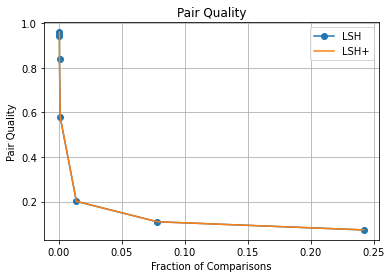

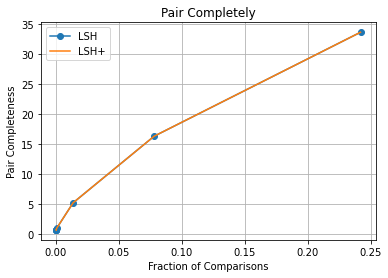

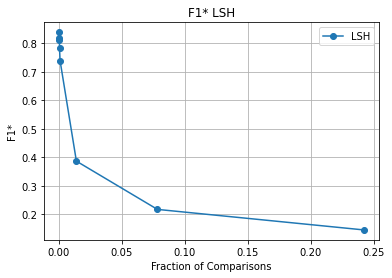

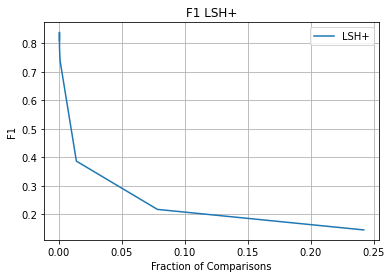

In [73]:
##-- Pair Quality
FracLSH = [0.000383496, 0.000400948, 0.000421739, 0.000460741, 0.000929071, 0.013856083576907086, 0.07819931465479302, 0.242006076]
FracS = [0.000383496, 0.000400948, 0.000421739, 0.000460741, 0.000929071, 0.013856083576907086, 0.07819931465479302, 0.242006076]

PQLSH = [0.9589566087071043, 0.945401282, 0.942058001, 0.837212911, 0.581182795, 0.20097317134299003, 0.1094178491016572, 0.07284265710146927]
PQS = [0.958956609, 0.945401282, 0.942058001, 0.837212911, 0.581182795, 0.20097317134299003, 0.1094178491016572, 0.072842657]
plt.plot(FracLSH, PQLSH, label='LSH', marker='o');
plt.plot(FracS, PQS, label='LSH+')
plt.title('Pair Quality'); plt.xlabel('Fraction of Comparisons'); plt.ylabel('Pair Quality'); plt.legend();
plt.grid(); plt.show()

##-- Pair Completeness
plt.figure()
PCLSH = [0.7015918958031838, 0.722720695, 0.757163531, 0.735166425, 1.02, 5.224891461649784, 16.311143270622285, 33.62083936]
PCS = [0.701591896, 0.722720695, 0.757163531, 0.735166425, 1.02, 5.224891461649784, 16.311143270622285, 33.62083936]
plt.plot(FracLSH, PCLSH, label='LSH', marker='o');
plt.plot(FracS, PCS, label='LSH+')
plt.title('Pair Completely'); 
plt.xlabel('Fraction of Comparisons'); plt.ylabel('Pair Completeness'); plt.legend(); plt.grid(); plt.show()

##-- F1 LSH
plt.figure()
F1 = [0.810228669, 0.818671072, 0.839119351, 0.782758649, 0.738717108, 0.3867398614584083, 0.21736995522811448, 0.145370356]
plt.plot(FracLSH, F1, label='LSH', marker='o')
plt.title('F1* LSH')
plt.xlabel('Fraction of Comparisons'); plt.ylabel('F1*'); plt.legend(); plt.grid(); plt.show()

plt.figure()
F1S = [0.810228669, 0.818671072, 0.839119351, 0.782758649, 0.738717108, 0.3867398614584083, 0.21736995522811448, 0.145370356]
plt.plot(FracS, F1S, label='LSH+')
plt.title('F1 LSH+')
plt.xlabel('Fraction of Comparisons'); plt.ylabel('F1'); plt.legend(); plt.grid(); plt.show()
